# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
tf.__version__

'2.15.0'

# TF Model to Convert to TFLite

In [ ]:
model = load_model(r'/content/drive/MyDrive/Model Files/Separated_BiDirectional_DCT_300.h5')

# TensorFlow Lite Conversion (No Quantization)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT] # can convert with and without optimizations, with makes size much smaller
# if the above doesn't work because input shape isn't static use the below:
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
# or better, make sure model input shape has fixed batch size

tflite_model = converter.convert()

In [ ]:
# Save the converted model to a .tflite file
with open('/content/drive/MyDrive/DCT_Def_noQ_300.tflite', 'wb') as f:
    f.write(tflite_model)

# Post-Training Integer Quantization

## Getting representative data from dataset (can be same as what was trained on)

In [ ]:
representative_data = np.load(r'/content/drive/MyDrive/Model Files/X_train_dct.npy')

In [ ]:
representative_data.shape

(7300, 5, 2025)

In [ ]:
p1_rep = representative_data[:1203]
p6_rep = representative_data[-1211:]

In [ ]:
rep_data = np.concatenate((p1_rep, p6_rep))

In [ ]:
rep_data.shape

(2414, 5, 2025)

## Conversion

In [ ]:
def representative_data_gen():
  for input_value in rep_data:
    yield [input_value.astype(np.float32)] # convert float64 to float32

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen # needs representative data

In [ ]:
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

In [ ]:
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

In [ ]:
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open('/content/drive/MyDrive/Model Files/DCT_Quant8.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
# check if conversion to uint8 worked
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


# Quantization-Aware Training

See the Quantize-Aware Notebook for training and conversion



# Checking Accuracies

## Test Dataset

In [ ]:
# Get testing dataset
X_test = np.load(r'/content/drive/My Drive/Model Files/X_test_300_cropped_dct.npy')
y_test = np.load(r'/content/drive/My Drive/Model Files/y_test_300_cropped_dct.npy')
num_classes = 94
# ohe the entire sequences of labels
y_test_ohe = np.zeros((y_test.shape[0], y_test.shape[1], num_classes), dtype=np.int32)
for i in range(y_test.shape[0]):
    y_test_ohe[i] = to_categorical(y_test[i], num_classes=num_classes)

## Interpreters

### Interpreter for Non-Quantized tflite

In [ ]:
# interpreter for non-quantized tflite
def interpreter_predict(seq):
  interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Model Files/DCT_Def_noQ_300.tflite")
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  interpreter.set_tensor(input_details[0]['index'], seq)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details[0]['index'])
  output = output.argmax(axis=-1)
  return output

### Interpreter for Quant8 tflite

In [ ]:
# interpreter for quant8 tflite
def interpreter_quant8(X_test_seq):
  interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Model Files/quant8_combined_model.tflite")
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]
  # Check if the input type is quantized, then rescale input data to uint8
  if input_details['dtype'] == np.uint8:
    input_scale, input_zero_point = input_details["quantization"]
    #print("input_details:\n", input_details)
    #print("input_scale: ", input_scale)
    #print("input_zero_point: ", input_zero_point)
    X_test_seq = X_test_seq / input_scale + input_zero_point
    X_test_seq = X_test_seq.astype(np.uint8)
  interpreter.set_tensor(input_details['index'], X_test_seq)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details['index'])
  #print(output_details)
  print(output)
  output = output.argmax(axis=-1)
  return output

### Interpreter for Quant-Aware tflite

In [ ]:
# interpreter for quant aware tflite
def interpreter_quantA(X_test_seq):
  interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Model Files/combinedQuantAware.tflite")
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]
  interpreter.set_tensor(input_details['index'], X_test_seq)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details['index'])
  #print(output_details)
  print(output)
  output = output.argmax(axis=-1)
  return output

### Compare test samples with all interpreters

In [ ]:
# Compare all labels manually
for i in range(320 + 36, 320 + 43): # any range of test samples
  sent_idx = i
  seq = X_test[sent_idx]
  seq = np.expand_dims(seq, axis=0)
  seq = seq.astype(np.float32)
  exp = y_test_ohe[sent_idx]

  c_res = model.predict(seq) #tf
  l_res = interpreter_predict(seq) #tflite
  q_res = interpreter_quant8(seq) #tflite quant8
  qa_res = interpreter_quantA(seq) #tflite quant aware
  comb_seq = []
  expec_seq = []

  for i in range(5):
      expec_seq.append(np.where(exp[i] == 1)[0][0])
      comb_seq.append(np.argmax(c_res[0][i]))

  print("true labels:",expec_seq)
  print("tensorflow labels:", comb_seq)
  print("tensorflow lite labels:", l_res)
  print("quantized integer tflite labels:", q_res)
  print("quantized aware tflite labels:", qa_res)


# Performance Metrics of TFLite

## data generator

In [ ]:
# prepare input by adding batch_size and convert from float64 to float32
def float_data_generator():
    for i in range(len(X_test)):
        seq = np.expand_dims(X_test[i], axis=0)
        seq = seq.astype(np.float32)
        yield seq, y_test[i]

## check accuracies for all padded lengths (all 5 words)

### Accuracy of Non-quantized Tflite




In [ ]:
# check accuracy for non-quantized tflite
total_labels = 0
correct_count = 0

for X_test_seq, exp_seq in float_data_generator():
  interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Model Files/combined_model.tflite")
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  interpreter.set_tensor(input_details[0]['index'], X_test_seq)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details[0]['index'])
  output = output.argmax(axis=-1)

  total_labels += len(X_test_seq[0])
  for predicted_label, expected_label in zip(output[0], exp_seq):
      if predicted_label == expected_label:
          correct_count += 1

accuracy = correct_count / total_labels
print("correct count:", correct_count)
print("total labels:", total_labels)
print("Testing accuracy:", accuracy)



correct count: 6664
total labels: 9210
Testing accuracy: 0.7235613463626493


### Accuracy of Quant8 Tflite

In [ ]:
# check accuracy for quant8 tflite
total_labels = 0
correct_count = 0

for X_test_seq, exp_seq in float_data_generator():
  interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Model Files/quant8_combined_model.tflite")
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # Check if the input type is quantized, then rescale input data to uint8
  if input_details['dtype'] == np.uint8:
    input_scale, input_zero_point = input_details["quantization"]
    X_test_seq = X_test_seq / input_scale + input_zero_point
    X_test_seq = X_test_seq.astype(np.uint8)

  interpreter.set_tensor(input_details['index'], X_test_seq)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details['index'])
  output = output.argmax(axis=-1)
  total_labels += len(X_test_seq[0])
  for predicted_label, expected_label in zip(output[0], exp_seq):
      if predicted_label == expected_label:
          correct_count += 1

accuracy = correct_count / total_labels
print("correct count:", correct_count)
print("total labels:", total_labels)
print("Testing accuracy:", accuracy)



correct count: 6284
total labels: 9210
Testing accuracy: 0.6823018458197612


### Accuracy of Quant-Aware Tflite


In [ ]:
# check accuracy for quant aware tflite
total_labels = 0
correct_count = 0

for X_test_seq, exp_seq in float_data_generator():
  interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Model Files/combinedQuantAware.tflite")
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  interpreter.set_tensor(input_details[0]['index'], X_test_seq)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details[0]['index'])
  output = output.argmax(axis=-1)

  total_labels += len(X_test_seq[0])
  for predicted_label, expected_label in zip(output[0], exp_seq):
      if predicted_label == expected_label:
          correct_count += 1

accuracy = correct_count / total_labels
print("correct count:", correct_count)
print("total labels:", total_labels)
print("Testing accuracy:", accuracy)



## check accuracies for correct sentence lengths (remove padding)





### Get predictions and expxected lists of non-quantized tflite

In [ ]:
# check accuracy for non-quantized tflite
pred_list = []
exp_list = []

for X_test_seq, exp_seq in float_data_generator():
  interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Model Files/DCT_Def_noQ_300.tflite")
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  interpreter.set_tensor(input_details[0]['index'], X_test_seq)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details[0]['index'])
  output = output.argmax(axis=-1)

  last = exp_seq[-1]
  pred_seq = output[0]
  i = 3
  while exp_seq[i] == last:
    exp_seq = exp_seq[:-1]
    pred_seq = pred_seq[:-1]
    i -= 1

  pred_list.append(pred_seq)
  exp_list.append(exp_seq)

Performance Metrics and Confusion Matrix

In [ ]:
accuracy = accuracy_score(flat_exp, flat_pred)
precision = precision_score(flat_exp, flat_pred, average='weighted')
recall = recall_score(flat_exp, flat_pred, average='weighted')
f1 = f1_score(flat_exp, flat_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.826534170153417
Precision: 0.8561253483265711
Recall: 0.826534170153417
F1-score: 0.8335664236952576


In [ ]:
# Flatten the lists
flat_pred = [item for sublist in pred_list for item in sublist]
flat_exp = [item for sublist in exp_list for item in sublist]

# Create the confusion matrix
conf_matrix = confusion_matrix(flat_exp, flat_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[30  0  0 ...  0  0  0]
 [ 0 30  0 ...  0  0  0]
 [ 0  0 41 ...  0  0  0]
 ...
 [ 0  0  0 ... 29  0  0]
 [ 0  0  0 ...  0 30  0]
 [ 0  0  0 ...  0  0 23]]


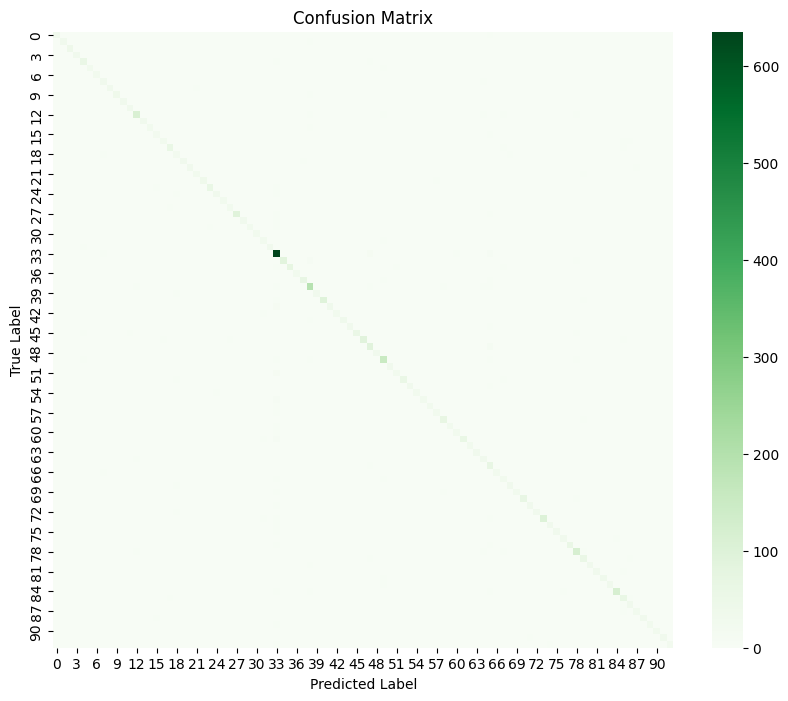

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, cmap="Greens")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Accuracy of Quant8 tflite with real sentence lengths

In [ ]:
# check accuracy for quant8 tflite
total_labels = 0
correct_count = 0

for X_test_seq, exp_seq in float_data_generator():
  interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Model Files/DCT_Quant8.tflite")
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # Check if the input type is quantized, then rescale input data to uint8
  if input_details['dtype'] == np.uint8:
    input_scale, input_zero_point = input_details["quantization"]
    X_test_seq = X_test_seq / input_scale + input_zero_point
    X_test_seq = X_test_seq.astype(np.uint8)

  interpreter.set_tensor(input_details['index'], X_test_seq)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details['index'])
  output = output.argmax(axis=-1)

  last = exp_seq[-1]
  pred_seq = output[0]
  i = 3
  while exp_seq[i] == last:
    exp_seq = exp_seq[:-1]
    pred_seq = pred_seq[:-1]
    i -= 1

  total_labels += len(pred_seq)

  for predicted_label, expected_label in zip(pred_seq, exp_seq):
      if predicted_label == expected_label:
          correct_count += 1

accuracy = correct_count / total_labels
print("correct count:", correct_count)
print("total labels:", total_labels)
print("Testing accuracy:", accuracy)



### Accuracy of Quant8 tflite with real sentence lengths

In [ ]:
# check accuracy for quant aware tflite with # words
total_labels = 0
correct_count = 0

for X_test_seq, exp_seq in float_data_generator():
  interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Model Files/combinedQuantAware.tflite")
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  interpreter.set_tensor(input_details[0]['index'], X_test_seq)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details[0]['index'])
  output = output.argmax(axis=-1)

  last = exp_seq[-1]
  pred_seq = output[0]
  i = 3
  while exp_seq[i] == last:
    exp_seq = exp_seq[:-1]
    pred_seq = pred_seq[:-1]
    i -= 1

  total_labels += len(pred_seq)
#  total_labels += len(X_test_seq[0])
  for predicted_label, expected_label in zip(pred_seq, exp_seq):
      if predicted_label == expected_label:
          correct_count += 1

accuracy = correct_count / total_labels
print("correct count:", correct_count)
print("total labels:", total_labels)
print("Testing accuracy:", accuracy)



correct count: 3922
total labels: 5736
Testing accuracy: 0.6837517433751743


### Checking number of parameters (not sure if correct)

In [ ]:
import numpy as np
import tensorflow as tf

# Load the TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Model Files/DCT_Def_noQ_300.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to count parameters
def count_parameters(tensors):
    total_params = 0
    for tensor in tensors:
        shape = tensor['shape']
        if isinstance(shape, list):
            shape = [s if s != -1 else 1 for s in shape]  # Replace -1 with 1
            total_params += np.prod(shape)
        else:
            total_params += shape
    return total_params

# Count parameters for input and output tensors
input_params = count_parameters(input_details)
output_params = count_parameters(output_details)

total_params = input_params + output_params
print("Total number of parameters:", total_params)


Total number of parameters: [   2   10 2119]
